In [1]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt

import math, time
import itertools
import datetime
from operator import itemgetter
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


import pandas as pd
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import Series

from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers import LSTM, TimeDistributed


Using TensorFlow backend.


## Load the stock data

### Choose CSV file of the company stock price

In [2]:
! ls

AAPL.csv		      NFLX.csv
AMZN.csv		      __pycache__
assessment_dsml1_train.csv    stock_LSTM-Copy1.ipynb
click_pred.ipynb	      stock_LSTM.ipynb
DSML1 - 4 - Assessment.ipynb  stock_LSTM-modular.ipynb
FB.csv			      Stock_LSTM_n.ipynb
FBdata.csv		      stock_modular.ipynb
fb.ipynb		      Stock-Predictor-using-LSTM.ipynb
files			      Stock_prices_m.zip
GOOG.csv		      Test.ipynb
lstm.py			      TSLA.csv
model.h5		      TSLAdata.csv
model.json		      Untitled.ipynb


In [3]:
import os
path =r'/home/aurobindo/Stock_prices/files'

os.chdir(path)
arr = os.listdir()
arr

['Facebook.csv', 'Amazon.csv', 'Apple.csv']

In [4]:
import glob

#path =r'/mapr_data/auro_157072/business_news/news_02/Stock/Files'
filenames = glob.glob(path + "/*.csv")

In [5]:
glob.glob(path +"/*.csv")

['/home/aurobindo/Stock_prices/files/Facebook.csv',
 '/home/aurobindo/Stock_prices/files/Amazon.csv',
 '/home/aurobindo/Stock_prices/files/Apple.csv']

In [6]:
arr[0][:-4]

'Facebook'

In [7]:
dfs = []
for index,filename in enumerate(filenames):
    df = pd.read_csv(filename)
    
    close_name = 'Close_' + arr[index][:-4]
    col_names = ['Timestamp','Sequence','Open','High','Low',close_name,'Volume']
    df.columns = col_names
    df['Timestamp'] =  pd.to_datetime(df['Timestamp'],format='%Y-%m-%d %H:%M:%S')
    df.index = df['Timestamp']
    df = df.drop(['Sequence','Timestamp'],axis =1)
    
    df = df[[close_name]]
    df = df.loc['2018-03-14']
    
    dfs.append(df)

In [8]:
len(dfs)

3

In [9]:
arr

['Facebook.csv', 'Amazon.csv', 'Apple.csv']

In [10]:
result = pd.concat(dfs, axis=1)
result.shape

(391, 3)

In [11]:
result.head(1)

,Close_Facebook,Close_Amazon,Close_Apple
Timestamp,,,
2018-03-14 13:30:00,182.6,1597.0,180.32


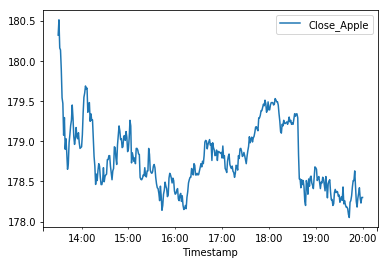

In [12]:
result.iloc[:, [2]].plot()

<Figure size 1080x576 with 0 Axes>

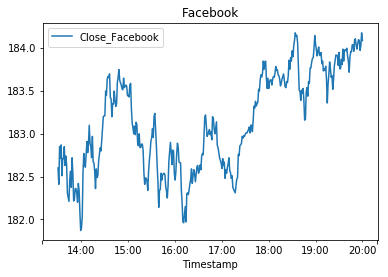

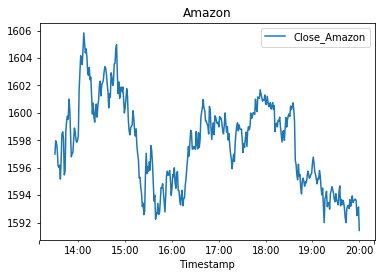

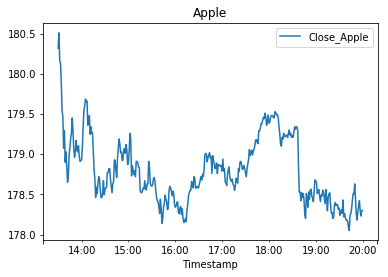

In [13]:
plt.figure(figsize=(15,8))

for i in range(len(dfs)):
    #plt.subplot(i,1,1)
    result.iloc[:, [i]].plot()
    plt.title(arr[i][:-4])


plt.legend()
plt.show()

In [14]:
train_data =result.iloc[:-50]
train_data.shape

(341, 3)

In [15]:
test_data = result.iloc[-50:]
test_data.shape

(50, 3)

In [16]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [17]:
result.iloc[:, [2]].head()

,Close_Apple
Timestamp,
2018-03-14 13:30:00,180.320
2018-03-14 13:31:00,180.510
2018-03-14 13:32:00,180.160
2018-03-14 13:33:00,180.135
2018-03-14 13:34:00,179.890


In [18]:
trains,train_scaleds,tests,test_scaleds  = [],[],[],[]

for i in range(len(dfs)):
    series = result.iloc[:, [i]]
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    supervised = timeseries_to_supervised(diff_values, 4)
    supervised_values = supervised.values
    train, test = supervised_values[0:-100], supervised_values[-100:]
    
    trains.append(train)
    tests.append(test)
    
    scaler, train_scaled, test_scaled = scale(train, test)
    train_scaleds.append(train_scaled)
    test_scaleds.append(test_scaled)

/home/aurobindo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [19]:
merge_train = np.insert(trains[0][:,:-1],[4],trains[1][:,:-1], axis=1)
merge_test = np.insert(tests[0][:,:-1],[4],tests[1][:,:-1], axis=1)

for i in range(len(dfs)-2):
    merge_train = np.insert(merge_train,[4 * (i+2)],trains[i+2][:,:-1], axis=1)
    merge_test  = np.insert(merge_test,[4 * (i+2)],tests[i+2][:,:-1], axis=1)
    

In [20]:
print(merge_train.shape)
print(merge_test.shape)

(290, 12)
(100, 12)


In [21]:
l_trains = []
l_tests = []
for i in range(len(dfs)):

    l_train = trains[i][:,-1].reshape(trains[i][:,-1].shape[0],1)
    l_test = tests[i][:,-1].reshape(tests[i][:,-1].shape[0],1)
    l_trains.append(l_train)
    l_tests.append(l_test)

In [22]:
merge_train_output = np.concatenate(tuple(l_trains),axis=1)
merge_test_output = np.concatenate(tuple(l_tests),axis=1)

In [23]:
print(merge_train_output.shape)
print(merge_test_output.shape)

(290, 3)
(100, 3)


In [24]:
import livelossplot
plot_losses = livelossplot.PlotLossesKeras()

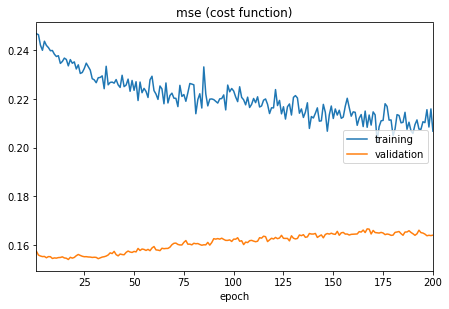

In [25]:
X, y = merge_train, merge_train_output
X = X.reshape(X.shape[0], 1, X.shape[1])
y = y.reshape(y.shape[0], 1, y.shape[1])

X_test, y_test = merge_test, merge_test_output
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])



model = Sequential()

'''
model.add(LSTM(12, batch_input_shape=(1, X.shape[1], X.shape[2]), stateful=False,return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(18,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(8,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=3))
model.add(Activation('linear'))

'''

dim_in = 12
dim_out = len(dfs)
nb_units = 8


model.add(LSTM(input_shape=(1, dim_in),
                    return_sequences=True, 
                    units=nb_units))

model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(activation='linear', units=dim_out)))
model.compile(loss = 'mse', optimizer = 'rmsprop')

#print(X.shape)
history = model.fit(X, y, epochs = 200, batch_size = 1,verbose=0,validation_data=(X_test, y_test),callbacks=[plot_losses])
              
              
#model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='rmsprop')
#model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False,callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')])

#for i in range(500):
#print("Completed :",i+1,"/",500, "Steps")
#model.fit(X, y, epochs=500, batch_size=1, verbose=0, shuffle=False,callbacks=[plot_losses])
#model.reset_states()

In [26]:
def forecast_lstm(model, X):
    y = model.predict(X)
    return y

ts = []
base_values = []

for i in range(len(dfs)):
    t = merge_train[-1:,4*i : 4*(i+1)]
    ts.append(t)
    base_values.append(result.iloc[290][i])

predictions = []

pred_apple = []
pred_amazon = []
pred_facebook = []

prediction = np.zeros((100,3))
prediction_i = np.zeros((100,3))

for i in range(100):
    
    temp = []
    for j in range(len(dfs)):
        temp.append(ts[j][:,i:])
    
    test_pred = np.concatenate(tuple(temp),axis=1)
    input_data = test_pred.reshape(1, 1, 4 *  len(dfs))
    
    y = forecast_lstm(model,input_data)
    prediction[i] = y[0]
    
    ys =[]
    
    for k in range(len(dfs)):
        ts[k] = np.insert(ts[k],[i+4],y[0][0][k], axis=1)
        
        temp = base_values[k] + y[0][0][k]
        prediction_i[i][k] = temp
    
sqrt(mean_squared_error(merge_test_output, prediction))    

0.39322258307747165

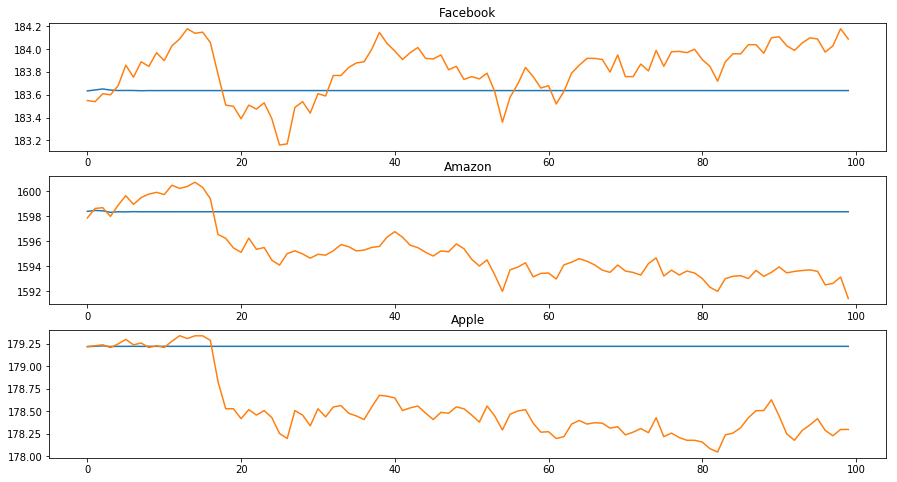

In [27]:
plt.figure(figsize=(15,8))
for i in range(len(dfs)):
    plt.subplot(3,1,i+1)
    plt.plot(prediction_i[:,i])
    plt.plot(result.iloc[:, [i]].iloc[-100:].values)
    plt.title(arr[i][:-4])
plt.show()   

# Parallal Process

In [28]:
print(merge_train.shape, merge_train_output.shape)

(290, 12) (290, 3)


In [29]:
from keras.models import Model
from keras.layers import *

In [33]:
def fit_lstm(features,labels):
    
    dim_in = 4
    dim_out = 1
    nb_units = 6
    
    features = features.reshape(features.shape[0], 1, features.shape[1])   
    labels = labels.reshape(labels.shape[0], 1, labels.shape[1])   
    
    feature1, label1 = merge_train[:,0:4],merge_train_output[:,0:1]
    feature1 = feature1.reshape(feature1.shape[0], 1, feature1.shape[1])   
    label1 = label1.reshape(label1.shape[0], 1, label1.shape[1])
    
    feature2, label2 = merge_train[:,4:8],merge_train_output[:,1:2]
    feature2 = feature2.reshape(feature2.shape[0], 1, feature2.shape[1])   
    label2 = label2.reshape(label2.shape[0], 1, label2.shape[1])
    
    feature3, label3 = merge_train[:,8:12],merge_train_output[:,2:3]
    feature3 = feature3.reshape(feature3.shape[0], 1, feature3.shape[1])   
    label3 = label3.reshape(label3.shape[0], 1, label3.shape[1])
    
    
    #joining the models
    inp1 = Input((1,4))

    #two inputs for model 2 (the model we want to run twice as fast)
    inp2 = Input((1,4))
    inp3 = Input((1,4))
        
    model = Sequential()
    model.add(LSTM(batch_input_shape=(1, features.shape[1], features.shape[2]),
                    return_sequences=True, 
                    units=8))
    model.add(Dropout(0.2))
    
    
    model.add(LSTM(6,return_sequences=True))
    model.add(Dropout(0.2))

    
    model.add(TimeDistributed(Dense(activation='linear', units=dim_out)))
    
    
    
    out1 = model(inp1)
    out2 = model(inp2)
    out3 = model(inp3)
    
    
    #out1 = model(feature1) #use model 2 once
    #out2 = model(feature2) 
    
    models = Model([inp1,inp2,inp3],[out1,out2,out3])
    
    #model.compile(loss = 'mse', optimizer = 'rmsprop')
    models.compile(loss='mean_squared_error', optimizer='adam')
    
    #model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False,callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')])

    
    
    for i in range(100):
        print("Completed :",i+1,"/",500, "Steps")
        #model.fit(features, labels, epochs=1, batch_size=1, verbose=0, shuffle=False)
        models.fit([feature1,feature2,feature3],[label1,label2,label3], epochs = 1,verbose=0,shuffle=False)
        models.reset_states()

    return models

In [34]:
print(merge_train[:,0:4].shape)
print(merge_train_output[:,0:1].shape)

(290, 4)
(290, 1)


In [35]:
models = fit_lstm(merge_train[:,0:4],merge_train_output[:,0:1])

Completed : 1 / 500 Steps
Completed : 2 / 500 Steps
Completed : 3 / 500 Steps
Completed : 4 / 500 Steps
Completed : 5 / 500 Steps
Completed : 6 / 500 Steps
Completed : 7 / 500 Steps
Completed : 8 / 500 Steps
Completed : 9 / 500 Steps
Completed : 10 / 500 Steps
Completed : 11 / 500 Steps
Completed : 12 / 500 Steps
Completed : 13 / 500 Steps
Completed : 14 / 500 Steps
Completed : 15 / 500 Steps
Completed : 16 / 500 Steps
Completed : 17 / 500 Steps
Completed : 18 / 500 Steps
Completed : 19 / 500 Steps
Completed : 20 / 500 Steps
Completed : 21 / 500 Steps
Completed : 22 / 500 Steps
Completed : 23 / 500 Steps
Completed : 24 / 500 Steps
Completed : 25 / 500 Steps
Completed : 26 / 500 Steps
Completed : 27 / 500 Steps
Completed : 28 / 500 Steps
Completed : 29 / 500 Steps
Completed : 30 / 500 Steps
Completed : 31 / 500 Steps
Completed : 32 / 500 Steps
Completed : 33 / 500 Steps
Completed : 34 / 500 Steps
Completed : 35 / 500 Steps
Completed : 36 / 500 Steps
Completed : 37 / 500 Steps
Completed 

In [37]:
input_data = np.copy(merge_train)
prediction = np.zeros((100,3))
prediction_i = np.zeros((100,3))
input_data = np.copy(merge_train[-1,:])


base_values = []


for i in range(len(dfs)):
    base_values.append(result.iloc[290][i])

for i in range(100):
    ts = []
    
    for m in range(len(dfs)):
        t = input_data[4*m + i : 4*(m+1) + i]
        t = t.reshape(1,1,4)
        
        ts.append(t)
    
    y = models.predict(ts)
    prediction[i] = np.concatenate(y, axis=1 ).reshape((1,1,len(dfs)))    
    for k in range(len(dfs)):
        input_data = np.insert(input_data,[i+4*(k+1)],y[k][0][0], axis=0)
        prediction_i[i][k] = base_values[k] + y[k][0][0]    
sqrt(mean_squared_error(merge_test_output, prediction))    

0.39333876252692773

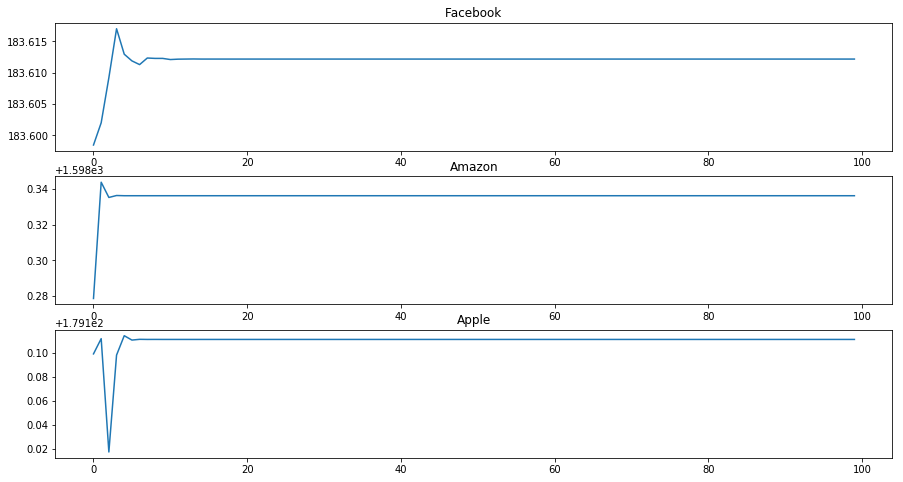

In [38]:
plt.figure(figsize=(15,8))
for i in range(len(dfs)):
    plt.subplot(3,1,i+1)
    plt.plot(prediction_i[:,i])
    plt.title(arr[i][:-4])
plt.show()  

# Using Subprocess

In [149]:
import livelossplot
plot_losses = livelossplot.PlotLossesKeras()

def fit_lstm(features,labels):
    
    dim_in = 4
    dim_out = 1
    nb_units = 6
    
    model = Sequential()
    model.add(LSTM(batch_input_shape=(1, features.shape[1], features.shape[2]),
                    return_sequences=True, 
                    units=4))
    model.add(Dropout(0.2))

    #model.add(LSTM(2,return_sequences=False))
    #model.add(Dropout(0.2))
    
    model.add((Dense(activation='linear', units=dim_out)))
    
    
    #model.compile(loss = 'mse', optimizer = 'rmsprop')
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    #model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False,callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')])

    for i in range(100):
        #print("Completed :",i+1,"/",500, "Steps")
        #model.fit(features, labels, epochs=1, batch_size=1, verbose=0, shuffle=False)
        #model.fit(features,labels, epochs = 1,batch_size=1,verbose=0,shuffle=False,callbacks=[plot_losses])
        model.fit(features,labels, epochs = 1, batch_size = 1,verbose=2)
        model.reset_states()

    return model

In [150]:
feature1, label1 = merge_train[:,0:4],merge_train_output[:,0:1]
feature1 = feature1.reshape(feature1.shape[0], 1, feature1.shape[1])   
label1 = label1.reshape(label1.shape[0], 1, label1.shape[1])

In [151]:
feature1.shape

(290, 1, 4)

In [152]:
label1.shape

(290, 1, 1)

In [153]:
model = fit_lstm(feature1,label1)

Epoch 1/1
 - 6s - loss: 0.0185
Epoch 1/1
 - 1s - loss: 0.0185
Epoch 1/1
 - 1s - loss: 0.0181
Epoch 1/1
 - 1s - loss: 0.0181
Epoch 1/1
 - 1s - loss: 0.0181
Epoch 1/1
 - 1s - loss: 0.0180
Epoch 1/1
 - 1s - loss: 0.0179
Epoch 1/1
 - 1s - loss: 0.0180
Epoch 1/1
 - 1s - loss: 0.0180
Epoch 1/1
 - 1s - loss: 0.0180
Epoch 1/1
 - 1s - loss: 0.0178
Epoch 1/1
 - 1s - loss: 0.0177
Epoch 1/1
 - 1s - loss: 0.0177
Epoch 1/1
 - 1s - loss: 0.0179
Epoch 1/1
 - 1s - loss: 0.0176
Epoch 1/1
 - 1s - loss: 0.0177
Epoch 1/1
 - 1s - loss: 0.0181
Epoch 1/1
 - 1s - loss: 0.0175
Epoch 1/1
 - 1s - loss: 0.0176
Epoch 1/1
 - 1s - loss: 0.0179
Epoch 1/1
 - 1s - loss: 0.0178
Epoch 1/1
 - 2s - loss: 0.0179
Epoch 1/1
 - 2s - loss: 0.0177
Epoch 1/1
 - 2s - loss: 0.0177
Epoch 1/1
 - 2s - loss: 0.0178
Epoch 1/1
 - 2s - loss: 0.0178
Epoch 1/1
 - 1s - loss: 0.0179
Epoch 1/1
 - 2s - loss: 0.0178
Epoch 1/1
 - 2s - loss: 0.0178
Epoch 1/1
 - 1s - loss: 0.0176
Epoch 1/1
 - 2s - loss: 0.0178
Epoch 1/1
 - 2s - loss: 0.0177
Epoch 1/

In [148]:
df.iloc[290].values

array([179.22])

In [ ]:
input_data = np.copy(merge_train)
prediction = np.zeros((100,3))
prediction_i = np.zeros((100,3))
input_data = np.copy(merge_train[-1,:])


base_values = []


for i in range(len(dfs)):
    base_values.append(result.iloc[290][i])

for i in range(100):
    ts = []
    
    for m in range(len(dfs)):
        t = input_data[4*m + i : 4*(m+1) + i]
        t = t.reshape(1,1,4)
        
        ts.append(t)
    
    y = models.predict(ts)
    prediction[i] = np.concatenate(y, axis=1 ).reshape((1,1,len(dfs)))    
    for k in range(len(dfs)):
        input_data = np.insert(input_data,[i+4*(k+1)],y[k][0][0], axis=0)
        prediction_i[i][k] = base_values[k] + y[k][0][0]    
sqrt(mean_squared_error(merge_test_output, prediction))    

In [ ]:
scaler, train_scaled, test_scaled = scale(train, test)
base_value = df.iloc[290].values

prediction = []
for i in range(100):
    
    input_data = test_scaled[:,i:-1]
    input_data = input_data.reshape(input_data.shape[1], 1, 1)
    y_hat = forecast_lstm(model,1,input_data)
    test_scaled = np.insert(test_scaled,[1],y_hat, axis=1)
    
    temp2 = invert_scale(scaler, input_data, y_hat)
    temp3 = base_value  + temp2
    base_value = temp3
    prediction.append(temp3)